In [44]:
%matplotlib inline
import numpy as np

import pandas as pd 
pd.__version__
from lmfit import Parameters, Model
import matplotlib.pyplot as plt
# Use the seborn style
#plt.style.use('seaborn')
#import tikzplotlib
import re
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF
from rdflib.plugins.sparql import prepareQuery

from shapely import Polygon, Point
from matolab_tools import annotate_csv_uri, csvw_to_rdf , create_mapping, get_joined_rdf 

#fetch sematic data and query for datasets and rois
PMD_CO=Namespace("https://w3id.org/pmd/co/")
OME=Namespace("https://github.com/Mat-O-Lab/OmeroExtractor/raw/main/ome.ttl#")
QUDT = Namespace("http://qudt.org/schema/qudt/")
OA = Namespace("http://www.w3.org/ns/oa#")
QUDT_UNIT_URL = 'https://raw.githubusercontent.com/qudt/qudt-public-repo/main/vocab/unit/VOCAB_QUDT-UNITS-ALL-v2.1.ttl'
QUNIT = Namespace("http://qudt.org/vocab/unit/")

units_graph = Graph()
units_graph.parse(QUDT_UNIT_URL, format='turtle')


def clean_string(string):
  return re.sub('[^A-Za-z0-9]+','', string )

def get_unit_symbol(qudt_unit):
  return str(units_graph.value(qudt_unit,QUDT.symbol))

def get_histogram(y,min_x=0,max_x=12.0,bin_width=1.0,x_label='x',plot_result=False) -> pd.DataFrame:
    #num_bins=int((max_x-min_x)/bin_width)
    y_label="normalized count"
    count, bin_edges= np.histogram(y,bins=np.arange(min_x,max_x,bin_width))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    hist=pd.DataFrame({'center': bin_centers, 'count': count})
    hist['norm']=hist['count']/hist['count'].sum()
    if plot_result:
        plt.figure()
        plt.bar(hist['center'], hist['count'], width=bin_width, alpha=0.5,align='center')
        plt.xlabel(x_label)
        plt.ylabel('count')
        plt.show()
    return hist

#log distrubition fumction
def rock(x, rm, sigma):
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

def fit_log_distribution(x, y, start=0.0,end=12.0, bin_width=1.0, x_label='x', plot_result=False) -> dict:
    results=dict()
    x_sim=np.linspace(start,end,300)
    #https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
    title="fitting log normal distribution"
    fit=pd.DataFrame(columns=('x','y','dely'))
    model = Model(rock)
    #params = model.make_params(sigma=3.0, rm=1.0)
    params = Parameters()
    #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
    params.add('sigma', value=1, min=0.1, max=100.0,vary=True)
    params.add('rm', value=5.0, min=0.5,max=100, vary=True)
    result = model.fit(y, params, x=x)
    print(result.fit_report())
    
    fit['x']=x_sim
    fit['y']=model.eval(x=x_sim, params=result.params)
    fit['dely'] = result.eval_uncertainty(x=x_sim)
    results['chi squared']=result.chisqr
    # results.at[key,'R squared']=result.rsquared
    # results.at[key,'amplitude']=result.params['amp'].value
    # results.at[key,'amplitude stderr']=result.params['amp'].stderr
    results['rm']=result.params['rm'].value
    results['rm stderr']=result.params['rm'].stderr
    results['sigma']=result.params['sigma'].value
    results['sigma stderr']=result.params['sigma'].stderr
    results['ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
    results['ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
    results['n_bins']=len(x)
    results['start']=start
    results['end']=end
    results['bin_width']=bin_width
    results['fit']=fit
    if plot_result:
        plt.figure()
        plt.title(title)
        plt.bar(x, y, width=bin_width, alpha=0.5,align='center')
        plt.plot(fit['x'], fit['y'], label='fit')
        plt.fill_between(fit['x'], fit['y']-fit['dely'],
               fit['y']+fit['dely'], color='#888888',alpha=0.3)
        plt.xlabel(x_label)
        plt.xlim(left=start)
        plt.ylim(bottom=0)
        plt.xticks(x)
        plt.ylabel('count')
        plt.show()
    return results

meta=Graph()
meta.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs-joined.ttl",format='turtle')
#meta.parse("./detection_runs-joined.ttl")
#add inverse relations
for s,p,o in meta.triples((None,PMD_CO.isResourceOf,None)):
   meta.add((o,PMD_CO.resource,s))
for s,p,o in meta.triples((None,PMD_CO.characteristic,None)):
   meta.add((o,PMD_CO.characteristicOf,s))
#meta.serialize('detection_runs-joined.ttl')

# Distribution Formula
$$X = \frac{1}{\sqrt{2 \pi} x \sigma} \exp{\left(-\frac{(\ln{x}-\ln{r_m})^2}{2 \sigma^2}\right)}$$

In [45]:
#fetching data from joined graph
q = prepareQuery(
    """
    SELECT ?ome_image ?ome_rois ?specimen_label ?chartype ?charvalue ?charunit WHERE 
    {
          ?image rdf:type co:Image ;
            co:resource ?ome_image.
          ?image_process co:output ?image ;
            co:nextProcess ?analysis_process ;
            co:input ?specimen .
          ?analysis_process co:output ?rois.
          ?rois co:resource ?ome_rois.
          ?creep_process co:nextProcess ?image_process;
            co:input [ a ?chartype;
              co:resource / qudt:value ?charvalue;
              co:resource / qudt:unit ?charunit].
          ?specimen co:characteristic [ a co:SpecimenName;
              co:resource / oa:hasBody / oa:value ?specimen_label].
    }
    """
    ,
    initNs = { "co": PMD_CO, "ome": OME, "rdf": RDF, "oa": OA, "qudt": QUDT}
)
qres = meta.query(q)
#print(list(qres)[:10])
df = pd.DataFrame(qres, columns =["ome_image", "ome_rois", "specimen_label", "parameter", "value", "unit"])
#remove rows names individual
df = df[df["parameter"] != URIRef("http://www.w3.org/2002/07/owl#NamedIndividual")]
result=df.iloc[:,0:3]#.set_index("ome_image")
params=df.loc[:,['ome_image',"parameter","value", "unit"]].set_index(["ome_image","parameter"])
params=params.unstack().reset_index()
params.columns = [' '.join((str2.rsplit('/',1)[-1],str1)).strip() for (str1,str2) in params.columns.values]

result.set_index('ome_image',inplace=True)
params.set_index('ome_image',inplace=True)
result=pd.concat([result, params.reindex(result.index)], axis=1).drop_duplicates()
#result['AgingTemperature unit symbol']=result['AgingTemperature unit'].map(get_unit_symbol)
result
result['dataset']= "T"+result['AgingTemperature value'].astype(str)+result['AgingTemperature unit'].map(get_unit_symbol)+'_'\
  "D"+result['AgingTime value'].astype(str)+result['AgingTime unit'].map(get_unit_symbol)+'_'\
  "S"+result['CreepStress value'].astype(str)+result['CreepStress unit'].map(get_unit_symbol)
data=result.reset_index().set_index(['dataset','ome_image']).to_dict('index')
data.keys()
data_dict=dict()
#data_dict={ dataset: {} for (dataset, index) in data.keys()}
for (dataset, index),value in data.items():
  if dataset not in data_dict.keys():
    data_dict[dataset]=dict()
  data_dict[dataset][index]=value
#data_dict

In [47]:
#fetch physical size of images
q = prepareQuery(
    """
    SELECT ?image ?sizex_value ?sizex_unit ?sizey_value ?sizey_unit WHERE 
    {
        ?image ome:relates_to / ome:physicalSizeX ?sizex ;
            ome:relates_to / ome:physicalSizeY ?sizey.
        ?sizex qudt:value ?sizex_value;
            qudt:unit ?sizex_unit.
        ?sizey qudt:value ?sizey_value;
            qudt:unit ?sizey_unit.
    }
    """
    ,
    initNs = { "qudt": QUDT, "ome": OME}
)
#df = pd.DataFrame(qres, columns =["image", "ome_image", "image_ds", "ome_image_ds", "rois", "ome_rois"])
pysicalsizes=dict()
for dataset, content in data_dict.items():
    images_graph=Graph()
    for image in content.keys():
        images_graph.parse(image,format='json-ld')
    qres = images_graph.query(q)
    df=pd.DataFrame(qres,columns =["image","sizex", "xunit", "sizey", "yunit"])
    df.set_index('image',inplace=True)
    pysicalsizes[dataset]=df
#pysicalsizes
    

In [48]:
# reshape countour data and calculate the polygon properties centroid, area, radius
poly_dict=dict()
for dataset, content in data_dict.items():
    contour_list=list()
    print("accessing {} with {} rois.".format(dataset,len(content)))
    rois=list()
    for image,record in content.items():
        shape_graph=Graph()
        rois.append(record['ome_rois'])
        shape_graph.parse(record['ome_rois'],format='json-ld')
        polygons_meta=shape_graph.subjects(RDF.type,OME.Polygon)
        #image_id=record['ome_rois'].rsplit('/',1)[-1]
        #reshape data
        contour_data=[shape_graph.value(polygon,OME.points).split(' ') for polygon in polygons_meta]
        contour_data=[[point.split(',')for point in contour] for contour in contour_data]
        #to pysical coords
        scale=[float(pysicalsizes[dataset].loc[image]['sizex']),float(pysicalsizes[dataset].loc[image]['sizey'])]
        contour_data=[np.array(contour).astype('float64')*scale for contour in contour_data]
        #print("{} contours with scale {} for {} image".format(len(contour_data),scale,image))
        contour_list+=contour_data
    #print(np.array(contour_data[0]))
    #calc polygon charakteristics
    polygon_props=list()
    polygons=[Polygon(contour) for contour in contour_list]
    for polygon in polygons:
        # calculate the distance from the centroid to each vertex
        centroid=Point(polygon.centroid)
        distances = [centroid.distance(Point(vertex)) for vertex in polygon.exterior.coords]
        # calculate the mean radius of the polygon, as mean of distance from centrois to exterior points
        mean_radius_edge = sum(distances) / len(distances)
        mean_radius_circle_area = np.sqrt(polygon.area/np.pi)
        polygon_props.append({'area': polygon.area, 'centroid': polygon.centroid, 'mean_radius_edge_distance': mean_radius_edge, 'mean_radius_circle_area': mean_radius_circle_area })
    df=pd.DataFrame(polygon_props)
    print('characterized {} polygons'.format(len(df)))
    poly_dict[dataset]={"dataframe": df, 'rois': rois}


accessing T190.0°C_D1000.0hr_S0MPa with 12 rois.
characterized 718 polygons
accessing T190.0°C_D8760.0hr_S0MPa with 19 rois.
characterized 637 polygons
accessing T23.0°C_D0.0hr_S0MPa with 13 rois.
characterized 1644 polygons
accessing T190.0°C_D25000.0hr_S0MPa with 21 rois.
characterized 464 polygons
accessing T190.0°C_D2500.0hr_S0MPa with 17 rois.
characterized 721 polygons
accessing T190.0°C_D250.0hr_S0MPa with 11 rois.
characterized 918 polygons
accessing T190.0°C_D5000.0hr_S0MPa with 23 rois.
characterized 1391 polygons


calculating distribution of T190.0°C_D1000.0hr_S0MPa with 718 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00337869
    reduced chi-square = 3.3787e-04
    Akaike info crit   = -94.1021008
    Bayesian info crit = -93.1322875
    R-squared          = 0.97417602
[[Variables]]
    sigma:  0.93347952 +/- 0.06075954 (6.51%) (init = 1)
    rm:     1.74426191 +/- 0.13867353 (7.95%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = -0.4951


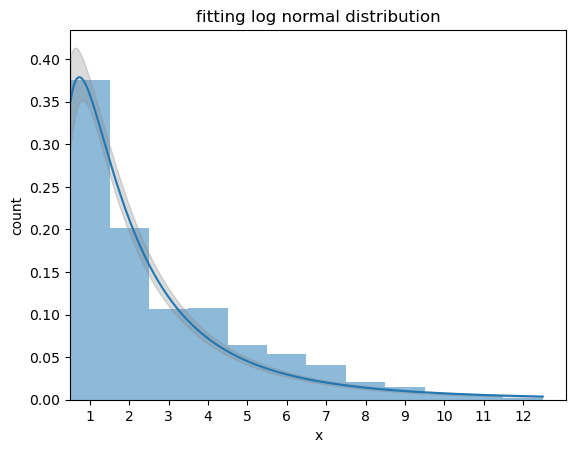

calculating distribution of T190.0°C_D8760.0hr_S0MPa with 637 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00990554
    reduced chi-square = 9.9055e-04
    Akaike info crit   = -81.1948096
    Bayesian info crit = -80.2249963
    R-squared          = 0.84240669
[[Variables]]
    sigma:  1.04851011 +/- 0.14679889 (14.00%) (init = 1)
    rm:     2.89730947 +/- 0.37822083 (13.05%) (init = 5)


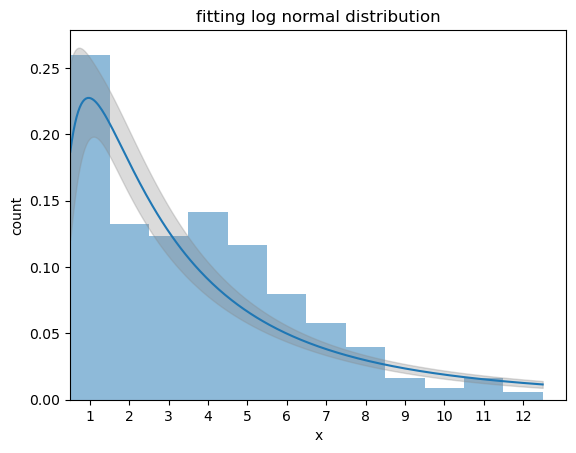

calculating distribution of T23.0°C_D0.0hr_S0MPa with 1644 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00130541
    reduced chi-square = 1.3054e-04
    Akaike info crit   = -105.513776
    Bayesian info crit = -104.543963
    R-squared          = 0.99503737
[[Variables]]
    sigma:  0.61789683 +/- 0.02193731 (3.55%) (init = 1)
    rm:     1.55873395 +/- 0.03013262 (1.93%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = -0.4541


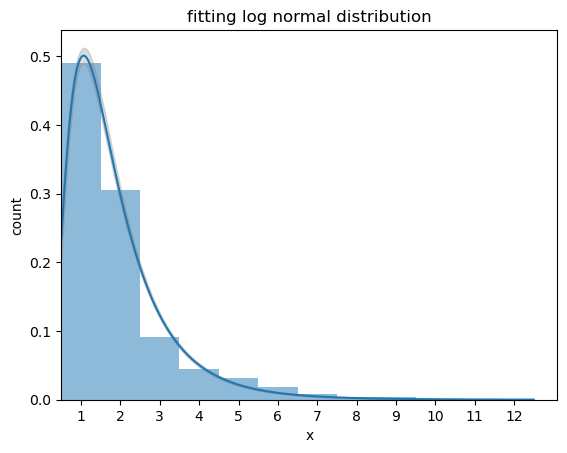

calculating distribution of T190.0°C_D25000.0hr_S0MPa with 464 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 12
    # variables        = 2
    chi-square         = 0.01527718
    reduced chi-square = 0.00152772
    Akaike info crit   = -75.9956214
    Bayesian info crit = -75.0258081
    R-squared          = 0.90709288
[[Variables]]
    sigma:  0.90616594 +/- 0.07994855 (8.82%) (init = 1)
    rm:     0.94073107 +/- 0.19985539 (21.24%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.1485


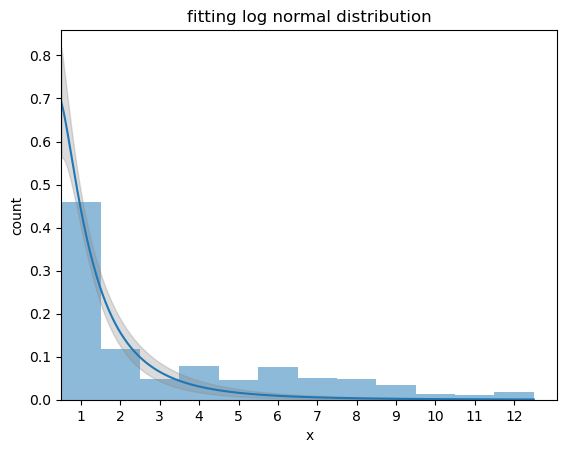

calculating distribution of T190.0°C_D2500.0hr_S0MPa with 721 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00240166
    reduced chi-square = 2.4017e-04
    Akaike info crit   = -98.1980461
    Bayesian info crit = -97.2282328
    R-squared          = 0.96692124
[[Variables]]
    sigma:  0.98410524 +/- 0.06339807 (6.44%) (init = 1)
    rm:     2.54572288 +/- 0.14595471 (5.73%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = -0.1348


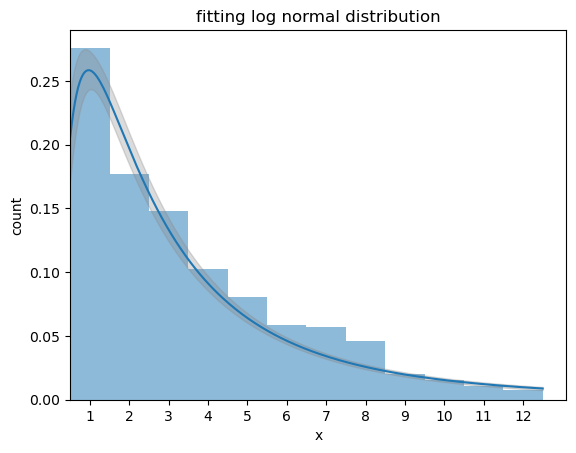

calculating distribution of T190.0°C_D250.0hr_S0MPa with 918 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00242130
    reduced chi-square = 2.4213e-04
    Akaike info crit   = -98.1003042
    Bayesian info crit = -97.1304909
    R-squared          = 0.98390183
[[Variables]]
    sigma:  0.88718788 +/- 0.04534277 (5.11%) (init = 1)
    rm:     1.60454153 +/- 0.10337640 (6.44%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = -0.5218


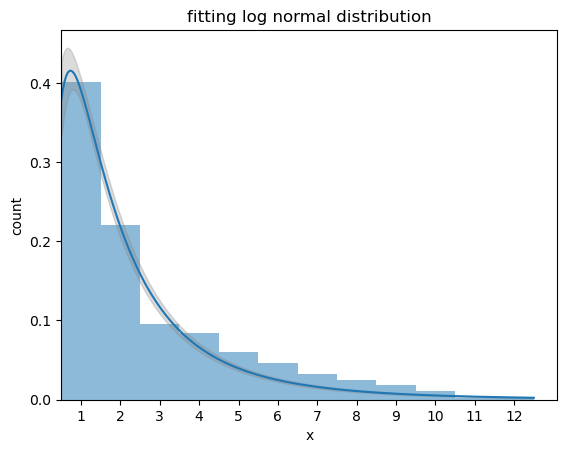

calculating distribution of T190.0°C_D5000.0hr_S0MPa with 1391 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00684548
    reduced chi-square = 6.8455e-04
    Akaike info crit   = -85.6288881
    Bayesian info crit = -84.6590748
    R-squared          = 0.97310153
[[Variables]]
    sigma:  0.75118765 +/- 0.03700822 (4.93%) (init = 1)
    rm:     1.04375636 +/- 0.10746066 (10.30%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = -0.1824


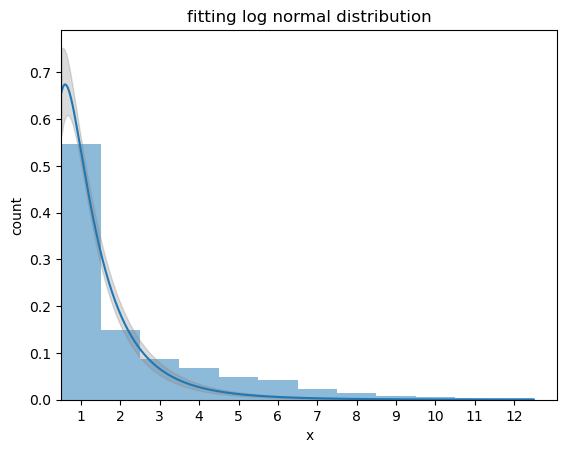

,rois,chi squared,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,n_bins,start,end,bin_width
dataset,,,,,,,,,,,,
T190.0°C_D1000.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/83...,0.003379,1.744262,0.138674,0.933480,0.060760,2.696686,0.214394,12,0.5,12.5,1.0
T190.0°C_D8760.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/26...,0.009906,2.897309,0.378221,1.048510,0.146799,5.020197,0.655347,12,0.5,12.5,1.0
T23.0°C_D0.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/51...,0.001305,1.558734,0.030133,0.617897,0.021937,1.886592,0.036471,12,0.5,12.5,1.0
T190.0°C_D25000.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/14...,0.015277,0.940731,0.199855,0.906166,0.079949,1.418316,0.301317,12,0.5,12.5,1.0
T190.0°C_D2500.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/86...,0.002402,2.545723,0.145955,0.984105,0.063398,4.131523,0.236874,12,0.5,12.5,1.0
T190.0°C_D250.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/72...,0.002421,1.604542,0.103376,0.887188,0.045343,2.378308,0.153228,12,0.5,12.5,1.0
T190.0°C_D5000.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/11...,0.006845,1.043756,0.107461,0.751188,0.037008,1.383986,0.142489,12,0.5,12.5,1.0


In [54]:
#ignoring zero division for fit, cause it can happen while iterating
np.seterr(divide='ignore',invalid='ignore')
# create histogram and fit distrbution to found polygon areas
fits=list()
for dataset, content in poly_dict.items():
    dataframe=content['dataframe']
    
    print("calculating distribution of {} with {} polygons.".format(dataset, len(dataframe)))
    #histogram=get_histogram(dataframe['mean_radius_circle_area'],plot_result=True)
    histogram=get_histogram(dataframe['mean_radius_circle_area'],0.5,13.5)
    record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'],0.5,12.5,plot_result=True)}
    #record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'])}
    record.pop('fit')
    fits.append({**{'dataset': dataset, "rois": " ".join(content['rois'])},**record})
fit_results=pd.DataFrame(fits).set_index('dataset')
fit_results.to_csv('fit_results.csv')
fit_results

In [56]:
# annotate fit_results.csv
response=annotate_csv_uri("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.csv")

csvw annotation file created, suggested name: fit_results-metadata.json
wrote csvw meta data to fit_results-metadata.json


In [63]:
# serialize table to rdf, uses already commited files on main branch
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
response=csvw_to_rdf(meta_url)

writen serialized table to fit_results.ttl


In [64]:
# create a rule bases mapping between the data in detection_runs and the precipitate analysis knowledge graph 
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
method_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/StatisticalAnalysisWorkflow.ttl"
d_classes= [
    "http://www.w3.org/ns/oa#Annotation",''
    "http://www.w3.org/ns/csvw#Column"
]
m_classes=["https://w3id.org/pmd/co/ValueObject",]
pred="https://w3id.org/pmd/co/isResourceOf"
map_dict={
    "ImageSet": "table-1-GID",
    "ImageSetName": "table-1-Dataset",
    "binWidth": "table-1-BinWidth",
    "x-Max": "table-1-End",
    "x-Min": "table-1-Start",
    "chisqrd": "table-1-ChiSquared",
    "r_a": "table-1-Ra",
    "r_m": "table-1-Rm",
    "sigma": "table-1-Sigma",
    "stderr_r_a": "table-1-RmStderr",
    "stderr_r_a": "table-1-RaStderr",
    "stderr_sigma": "table-1-SigmaStderr",
}
create_mapping(meta_url=meta_url,method_url=method_url,data_super_classes=d_classes,predicate=pred,method_super_classes=m_classes,map_dict=map_dict)

writen mapping file to fit_results-map.yaml


True

In [65]:
# join all data and replicate template knowledge graph for every row in table
mapping_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-map.yaml"
data_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.ttl"
duplicate_for_table = True
get_joined_rdf(map_url=mapping_url,data_url=data_url,duplicate_for_table=duplicate_for_table)


applied 10 mapping rules and skipped 0
wrote joint graph to fit_results-joined.ttl


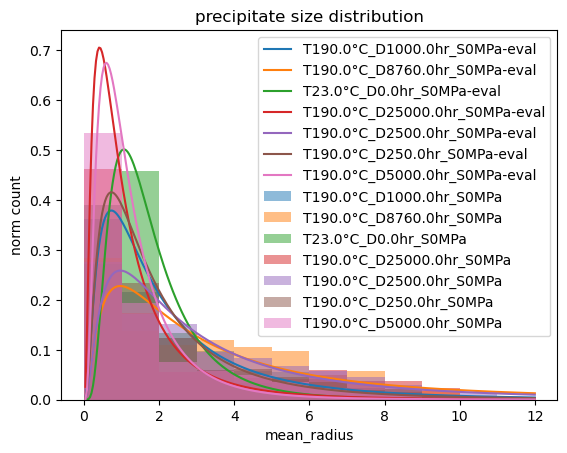

In [73]:
#plot all histograms
title='precipitate size distribution'
plt.figure()
for dataset, dataframe in poly_dict.items():
  histogram=get_histogram(dataframe['mean_radius_circle_area'])
  plt.bar(histogram['center'],histogram['norm'], width=1.0, alpha=0.5,align='center',label=dataset)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  model = Model(rock)
  params = Parameters()
  params.add('rm', value=fit_results.at[dataset,'rm'])
  params.add('sigma', value=fit_results.at[dataset,'sigma'])
  x_sim=np.linspace(0,12.0,300)
  sim=model.eval(x=x_sim, params=params)
  #plt.plot(x_sim, rock(x_sim, rm=fit_results.at[dataset,'rm'],sigma=fit_results.at[dataset,'sigma']), label=dataset+'-eval')
  plt.plot(x_sim, sim, label=dataset+'-eval')
  #plt.fill_between(x_sim, sim-dsim,
  #              sim+dsim, color='#888888',alpha=0.3)
  #break
plt.title(title)
plt.xlabel('mean_radius')
plt.ylabel('norm count')
plt.legend()
plt.show()
  #tikzplotlib.save("{}.tex".format(title.replace(' ','_')))